In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
import seaborn as sns

In [2]:
#!pip install openpyxl Juhul jui juba olemas ei ole

## Andmete töötlemine

In [3]:
def load_data(file):
    
    # Data
    data = pd.read_csv(file)
    pd.set_option('display.max_rows', 20)
    surnud= data[data["DEFINITION_ID"] == "death"]
    subject_ids = surnud["SUBJECT_ID"]
    
    # FIltreerib surnute id põhjal
    surnud = data[data["SUBJECT_ID"].isin(subject_ids)]
    surnud["TIME"] = 1 # Muudame aja väärtuse 1-ks, ehk esialgsetes andmetes "DEFINITION_ID" = TIME, nüüd selle asemel 
    # lihtsalt 1.
    elus = data[data["DEFINITION_ID"] != "death"]
    elus["TIME"] = 1

    # Sama toimub ka siin, aga elus patsientidega
    elus_filtered = elus[~elus["SUBJECT_ID"].isin(surnud["SUBJECT_ID"])]

    # Filtreeritud andmete kombineerimine üheks tabeliks
    combined_data = pd.concat([surnud, elus_filtered])
    combined_data.sort_values(by='SUBJECT_ID', inplace=True)
    combined_data.reset_index(drop=True, inplace=True)
    
    #Viimane tabel-  kus read on patsiendid, veerud protseduurid vastavalt
    # 1- protseduur tehti, 0 - patsient pole protseduuri saanud. samuti ka veerg "death": 1-surnud, 0 -"elus"
    
    pivot_combined_data = combined_data.pivot_table(index='SUBJECT_ID', columns='DEFINITION_ID', values='TIME', aggfunc='sum', fill_value=0)
    return pivot_combined_data

## Tunnuste töötlemine (PCA)

In [4]:
def identify_important_features(X, save_loadings=False):
    n_components=20
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    # DataFrame with the principal components
    pc_columns = [f'PC_{i+1}' for i in range(n_components)]
    
    # Variance ratios
    explained_variance_ratio = pca.explained_variance_ratio_ 
    
    all_pca_loadings = [loadings for loadings in pca.components_]
    
    if save_loadings:
        loadings_dfs = []
        for index, loadings in enumerate(all_pca_loadings):
            loadings_df = pd.DataFrame({'Feature': X.columns, f'Loading_PC{index+1}': loadings})
            loadings_df[f'Absolute_Loading_PC{index+1}'] = loadings_df[f'Loading_PC{index+1}'].abs()
            loadings_df = loadings_df.sort_values(by=f'Absolute_Loading_PC{index+1}', ascending=False)
            loadings_dfs.append(loadings_df)
        
        combined_loadings_df = pd.concat(loadings_dfs, axis=1)
        combined_loadings_df.to_csv('combined_loadings.csv', index=False, encoding="utf-8")
    print(f'Explained Variance Ratio - PC1: {explained_variance_ratio[0]:.4f}')
    print(f'Explained Variance Ratio - PC2: {explained_variance_ratio[1]:.4f}')
    print(f'Explained Variance Ratio - PC3: {explained_variance_ratio[2]:.4f}')
    print(f'Explained Variance Ratio - PC4: {explained_variance_ratio[3]:.4f}')
    
    loadings_pc = pca.components_[0]
    
    # saaks kätte kõige olulisemad feature nimed
    loading_df = pd.DataFrame({'Feature': X.columns, 'Loading_PC1': loadings_pc})
    
    # Sorteeritud
    loading_df['Absolute_Loading_PC1'] = loading_df['Loading_PC1'].abs()
    loading_df = loading_df.sort_values(by='Absolute_Loading_PC1', ascending=False)
    
    return pd.DataFrame(X_pca, columns=pc_columns), explained_variance_ratio, pca, loading_df

## Erinevate mudelite treenimine, valimaks parima mudeli

In [5]:
def train_model(X, y, model_type):
    svm_params = {'kernel': 'poly', 'gamma': 'scale', 'degree': 4, 'C': 100}
    knn_params = {'weights': 'distance', 'p': 2, 'n_neighbors': 16, 'algorithm': 'auto'}
    rf_params = {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
    gradient_params = {'learning_rate': 0.2, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.8}
    if model_type == 'RandomForest':
        model = RandomForestClassifier(random_state=42,**rf_params)
    elif model_type == 'SVM':
        model = SVC(probability=True, random_state=42,**svm_params)
    elif model_type == 'KNeighbors':
        model = KNeighborsClassifier(**knn_params)
    elif model_type == "Gradient":
        model = GradientBoostingClassifier(random_state=42,**gradient_params)
    
    else:
        raise ValueError(f'Invalid model type: {model_type}')
    
    model.fit(X, y)
    return model

## Mudeli hindamine

In [6]:
def evaluate_model(model, X, y):
    # Mudeli hindamine 
    y_probabilities = model.predict_proba(X)[:, 1]    
    auc_roc = roc_auc_score(y, y_probabilities)
    
    return auc_roc

## Töövoo jooksutamine
**PS! Vaata #STEP 2 juures kommentaar "save_loadings"**

In [7]:
def main(file):
    
    # Step 1: Load data
    data = load_data(file)
    X = data.drop(columns=['death'])
    y = data['death']
    
    # Step 2: important features
        # PANNA "save_loadings=True" et tekiks uus csv fail kust saame hiljem tunnuste osakaalu PCA-de moodustamisel vaadata
    important_features, explained_variance_ratio, pca, loading_df = identify_important_features(X,save_loadings=True)
    
    model_types = ['RandomForest','SVM', 'KNeighbors','Gradient'] #Different models to try
    results = {} #Results
    
    # Step 3: Mudelite treenimine (important_features ehk saadud PCA eelnevas sammus)
    X_train, X_test, y_train, y_test = train_test_split(important_features, y, test_size=0.2, random_state=42)
    for model_type in model_types:
        
        model = train_model(X_train, y_train, model_type=model_type)
        if model_type != 'SVM' and model_type != "KNeighbors":
            print(F"\n{model_type} feature importances:\n{model.feature_importances_}\n")
        auc_roc = evaluate_model(model, X_test, y_test)
        results[model_type] = auc_roc
        print(f'{model_type} AUC-ROC: {auc_roc}')

    return results

# KASUTAMINE! - File_path = jooksutav csv fail!
file_path ="synthetic_data_lung_cancer.csv"

# Run the main script
results = main(file_path)
print("\nAUC-ROC Scores:")
for model_type, auc_roc in results.items():
    print(f'{model_type}: {auc_roc}')


C:\Users\rober\AppData\Local\Temp\ipykernel_4692\2053188126.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surnud["TIME"] = 1 # Muudame aja väärtuse 1-ks, ehk esialgsetes andmetes "DEFINITION_ID" = TIME, nüüd selle asemel
C:\Users\rober\AppData\Local\Temp\ipykernel_4692\2053188126.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elus["TIME"] = 1


Explained Variance Ratio - PC1: 0.2754
Explained Variance Ratio - PC2: 0.0501
Explained Variance Ratio - PC3: 0.0374
Explained Variance Ratio - PC4: 0.0312

RandomForest feature importances:
[0.17567312 0.07491509 0.13935841 0.03765024 0.03987066 0.04162304
 0.02566825 0.0215508  0.03433842 0.02209462 0.06693775 0.06164359
 0.05797967 0.02252342 0.02310632 0.02859659 0.02779719 0.03356667
 0.03233945 0.03276671]

RandomForest AUC-ROC: 0.8220817340257394
SVM AUC-ROC: 0.8773989613908332
KNeighbors AUC-ROC: 0.8509821630164823

Gradient feature importances:
[0.27798279 0.04121422 0.11814119 0.03454222 0.03302713 0.02087984
 0.02363673 0.01453123 0.03705288 0.010149   0.07486164 0.05570715
 0.06167133 0.02590579 0.01895244 0.0324914  0.01807079 0.04493701
 0.02737359 0.02887163]

Gradient AUC-ROC: 0.8751411153759314

AUC-ROC Scores:
RandomForest: 0.8220817340257394
SVM: 0.8773989613908332
KNeighbors: 0.8509821630164823
Gradient: 0.8751411153759314


In [22]:
loadings = pd.read_csv("combined_loadings.csv")
pd.set_option('display.float_format', lambda x: '%.9f' % x)
loadings.sort_values(by='Loading_PC1', ascending=False)
loadings # Siin peaks teil loadings df avanema kui kõik töötas nii nagu pidi

,Feature,Loading_PC1,Absolute_Loading_PC1,Feature.1,Loading_PC2,Absolute_Loading_PC2,Feature.2,Loading_PC3,Absolute_Loading_PC3,Feature.3,...,Absolute_Loading_PC17,Feature.17,Loading_PC18,Absolute_Loading_PC18,Feature.18,Loading_PC19,Absolute_Loading_PC19,Feature.19,Loading_PC20,Absolute_Loading_PC20
0,measurement_637,0.029168362,0.029168362,measurement_637,-0.017190785,0.017190785,measurement_637,-0.035744636,0.035744636,measurement_637,...,0.005947244,measurement_637,0.002058148,0.002058148,measurement_637,0.001693586,0.001693586,measurement_637,-0.016392723,0.016392723
1,observation_204,0.028583363,0.028583363,observation_204,0.052606380,0.052606380,observation_204,-0.002151044,0.002151044,observation_204,...,0.040165138,observation_204,0.038898372,0.038898372,observation_204,-0.034937501,0.034937501,observation_204,0.006606397,0.006606397
2,observation_224,0.028193940,0.028193940,observation_224,0.041922408,0.041922408,observation_224,0.004933474,0.004933474,observation_224,...,0.030767211,observation_224,-0.063689533,0.063689533,observation_224,-0.026163280,0.026163280,observation_224,0.011224097,0.011224097
3,measurement_422,0.028161917,0.028161917,measurement_422,-0.016644321,0.016644321,measurement_422,-0.035846480,0.035846480,measurement_422,...,0.000455524,measurement_422,0.008281854,0.008281854,measurement_422,0.011319691,0.011319691,measurement_422,-0.023531958,0.023531958
4,measurement_1221,0.028010169,0.028010169,measurement_1221,-0.012115443,0.012115443,measurement_1221,-0.034729065,0.034729065,measurement_1221,...,0.002735119,measurement_1221,0.009172837,0.009172837,measurement_1221,0.017009140,0.017009140,measurement_1221,-0.017787849,0.017787849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4858,condition_2161,0.001544834,0.001544834,condition_2161,0.004885876,0.004885876,condition_2161,0.002883829,0.002883829,condition_2161,...,0.009138218,condition_2161,0.009927356,0.009927356,condition_2161,-0.016097958,0.016097958,condition_2161,-0.019379899,0.019379899
4859,condition_2394,0.001499700,0.001499700,condition_2394,0.002473619,0.002473619,condition_2394,0.006337566,0.006337566,condition_2394,...,0.003868010,condition_2394,0.009958039,0.009958039,condition_2394,0.006336428,0.006336428,condition_2394,0.001385187,0.001385187
4860,condition_1750,0.001422504,0.001422504,condition_1750,0.003595895,0.003595895,condition_1750,0.000243771,0.000243771,condition_1750,...,0.003897887,condition_1750,0.007402219,0.007402219,condition_1750,-0.013327725,0.013327725,condition_1750,-0.021736100,0.021736100
4861,condition_53,0.001403384,0.001403384,condition_53,0.006980164,0.006980164,condition_53,-0.001001264,0.001001264,condition_53,...,0.015924106,condition_53,0.008711002,0.008711002,condition_53,-0.020262306,0.020262306,condition_53,-0.014545837,0.014545837


## PCA analüüs

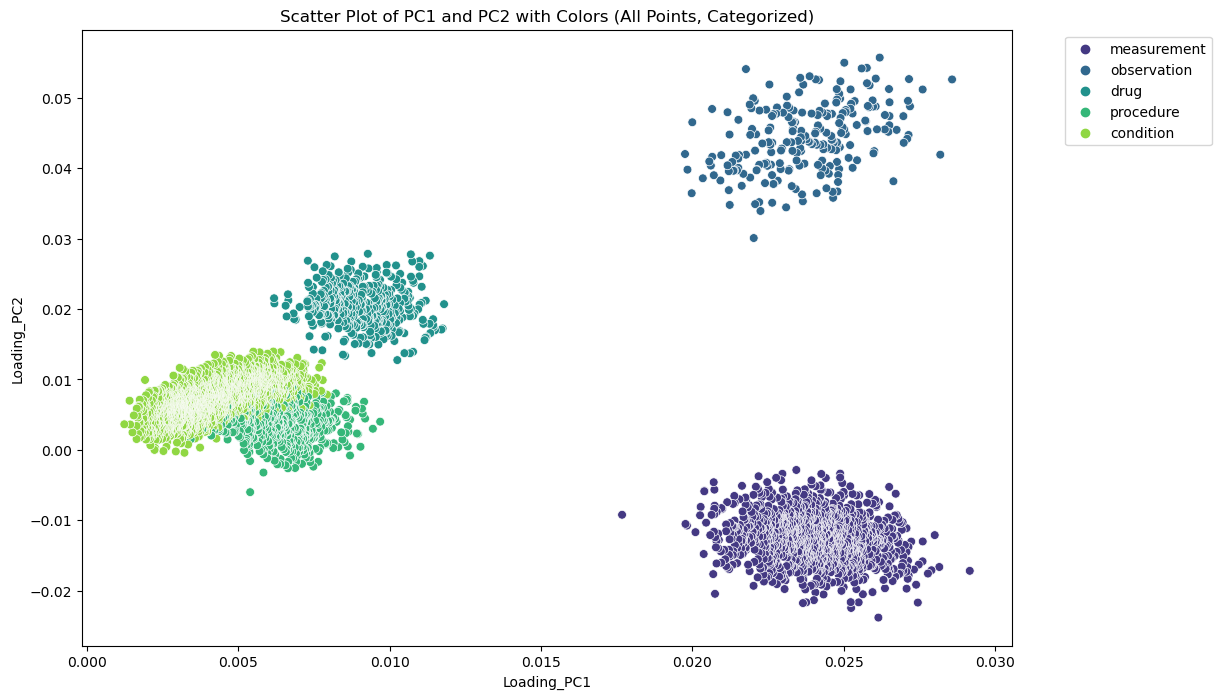

In [23]:
# Kategooriad
loadings['Category'] = loadings['Feature'].apply(lambda x: x.split('_')[0])

# Scatter plot loadingutest
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x=loadings['Loading_PC1'], y=loadings['Loading_PC2'], hue=loadings['Category'], palette='viridis', s=40)

plt.title('Scatter Plot of PC1 and PC2 with Colors (All Points, Categorized)')
plt.xlabel('Loading_PC1')
plt.ylabel('Loading_PC2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.show()


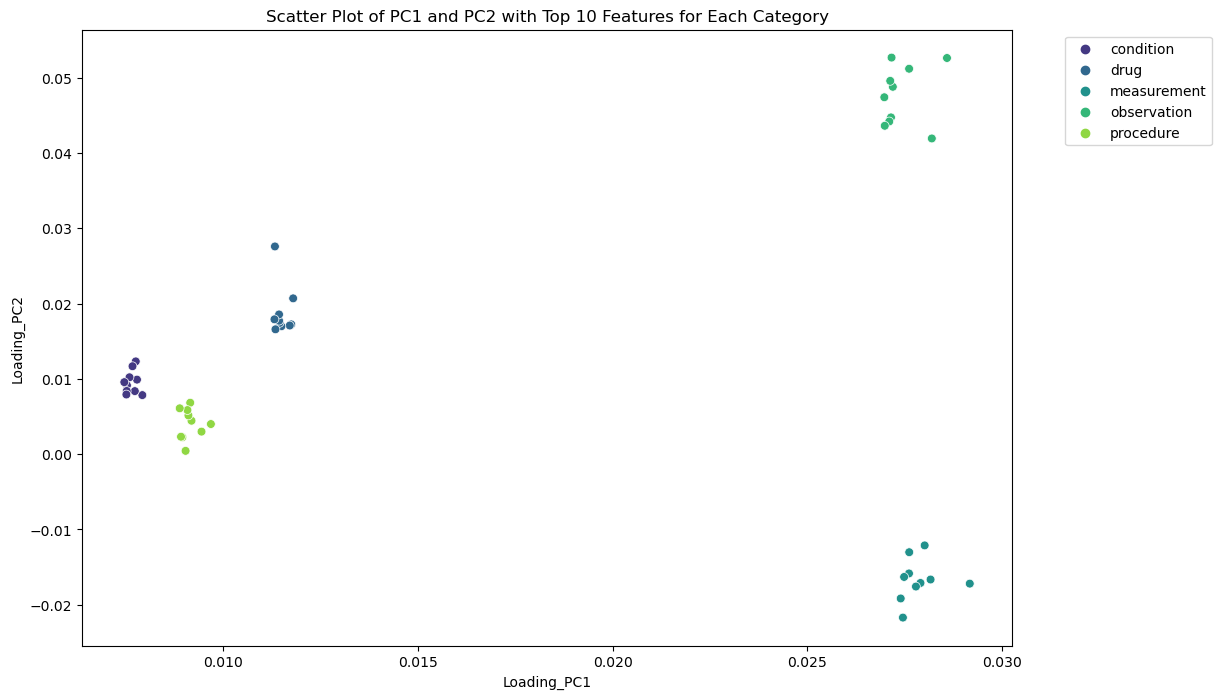

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

loadings['Category'] = loadings['Feature'].apply(lambda x: x.split('_')[0])

# Iga kategooria top 15 tunnust
top_features_by_category = loadings.groupby('Category').apply(lambda x: x.nlargest(10, 'Loading_PC1')).reset_index(drop=True)

# Scatter plot top 10
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x=top_features_by_category['Loading_PC1'], y=top_features_by_category['Loading_PC2'],
                          hue=top_features_by_category['Category'], palette='viridis', s=40)

plt.title('Scatter Plot of PC1 and PC2 with Top 10 Features for Each Category')
plt.xlabel('Loading_PC1')
plt.ylabel('Loading_PC2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot

# Top tunnuste dataframe
top_features_df = top_features_by_category[['Category', 'Feature', 'Loading_PC1', 'Loading_PC2']].copy()
top_features_df.columns = ['Category', 'Top_Feature', 'PC1_Value', 'PC2_Value']



In [25]:
pd.set_option('display.max_rows', 50)

top_features_df = top_features_df.sort_values(by='PC1_Value', ascending=False)
top_features_df # Sorteeritud PC1 järgi

,Category,Top_Feature,PC1_Value,PC2_Value
20,measurement,measurement_637,0.029168362,-0.017190785
30,observation,observation_204,0.028583363,0.052606380
31,observation,observation_224,0.028193940,0.041922408
21,measurement,measurement_422,0.028161917,-0.016644321
22,measurement,measurement_1221,0.028010169,-0.012115443
23,measurement,measurement_1076,0.027902880,-0.017104783
24,measurement,measurement_1027,0.027786059,-0.017576854
25,measurement,measurement_111,0.027613864,-0.013018503
32,observation,observation_138,0.027611075,0.051179713
26,measurement,measurement_720,0.027608109,-0.015837897


In [26]:
top_features_df['Sum_PC1_PC2'] = top_features_df['PC1_Value'] + top_features_df['PC2_Value']
top_features_df_sorted = top_features_df.sort_values(by='Sum_PC1_PC2', ascending=False)
top_features_df_sorted = top_features_df_sorted.drop(columns=['Sum_PC1_PC2'])
top_features_df_sorted # Sorteeritud PC1 ja PC2 järgi

,Category,Top_Feature,PC1_Value,PC2_Value
30,observation,observation_204,0.028583363,0.052606380
34,observation,observation_38,0.027160047,0.052661626
32,observation,observation_138,0.027611075,0.051179713
36,observation,observation_30,0.027126337,0.049570005
33,observation,observation_51,0.027192830,0.048782295
39,observation,observation_80,0.026974439,0.047393677
35,observation,observation_63,0.027145511,0.044719150
37,observation,observation_215,0.027101543,0.044178765
38,observation,observation_98,0.026985815,0.043605280
31,observation,observation_224,0.028193940,0.041922408


## Korrelatsioonimaatriks
**(Proovime võimalikult palju infot tunnuste kohta hankida kui võimalik juhul kui PCA loadingutest ei piisa)**

In [13]:
file = "synthetic_data_lung_cancer.csv" # LISAGE SIIA OMA FAIL

In [14]:
file                 
data = load_data(file)
correlation_matrix = data.corr()
correlation_with_target = correlation_matrix['death'].abs().sort_values(ascending=False)
correlation_with_target.to_csv('correlation_results.csv', header=True)
correlations = pd.read_csv("correlation_results.csv")
correlations # Siin peaks teil correlations df avanema kui kõik töötas nii nagu pidi

C:\Users\rober\AppData\Local\Temp\ipykernel_4692\2053188126.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surnud["TIME"] = 1 # Muudame aja väärtuse 1-ks, ehk esialgsetes andmetes "DEFINITION_ID" = TIME, nüüd selle asemel
C:\Users\rober\AppData\Local\Temp\ipykernel_4692\2053188126.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elus["TIME"] = 1


,DEFINITION_ID,death
0,death,1.000000
1,measurement_258,0.308031
2,measurement_601,0.307923
3,measurement_817,0.305948
4,measurement_1325,0.305563
...,...,...
4859,condition_434,0.000991
4860,condition_1834,0.000696
4861,condition_1885,0.000189
4862,condition_1685,0.000032


## Mutual information
**Mutual information measures the dependence between two random variables<br>Helps to Identify which features are more informative for predicting the target variable in a classification problem. Higher mutual information scores imply a stronger relationship between a feature and the target.**

In [15]:
file# = "synthetic_data_lung_cancer.csv"
data = load_data(file)
X = data.drop(columns=['death'])
y = data['death']


mutual_info = mutual_info_classif(X, y,random_state=42)

# Create a DataFrame with feature names and their mutual information scores
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Information': mutual_info})

# Sort features by mutual information scores (descending order)
mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False)

print(mi_df.head(10))

mi_df.to_csv('mutual_information_results.csv', index=False)
mutual_information = pd.read_csv("mutual_information_results.csv")
mutual_information # Siin peaks teil mutual_information df avanema kui kõik töötas nii nagu pidi

C:\Users\rober\AppData\Local\Temp\ipykernel_4692\2053188126.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surnud["TIME"] = 1 # Muudame aja väärtuse 1-ks, ehk esialgsetes andmetes "DEFINITION_ID" = TIME, nüüd selle asemel
C:\Users\rober\AppData\Local\Temp\ipykernel_4692\2053188126.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elus["TIME"] = 1


               Feature  Mutual_Information
3321   measurement_253            0.093112
3630   measurement_531            0.087619
2233      condition_85            0.084881
3180  measurement_1325            0.084747
3969   measurement_837            0.084734
3400   measurement_324            0.083806
3862   measurement_740            0.083265
3253   measurement_192            0.082363
3620   measurement_522            0.080798
4092   measurement_948            0.080770


,Feature,Mutual_Information
0,measurement_253,0.093112
1,measurement_531,0.087619
2,condition_85,0.084881
3,measurement_1325,0.084747
4,measurement_837,0.084734
...,...,...
4858,condition_2365,0.000000
4859,condition_2367,0.000000
4860,condition_2369,0.000000
4861,condition_237,0.000000


# SMOTE kasutamine

**SMOTE kasutamises ei ole me kindlad, kas seda on õige kasutada reaalsete andmete peal, aga treening ja valideerimise andmetel läheb auc-roc skoor kõvasti paremaks<br>Sellegipoolest ei ole me kindlad, et kas seda on mõistlik terviseandmete peal kasutada seega see on hetkel pigem lihtsalt siia kerge lisa ja kui leiate, et SMOTE kasutamine oleks okei siis integreeriksime selle oma töövoogu sisse**

In [16]:


# Function to load data
def load_data(file):
    data = pd.read_csv(file)
    surnud = data[data["DEFINITION_ID"] == "death"]
    subject_ids = surnud["SUBJECT_ID"]
    surnud = data[data["SUBJECT_ID"].isin(subject_ids)]
    surnud["TIME"] = 1
    elus = data[data["DEFINITION_ID"] != "death"]
    elus["TIME"] = 1
    elus_filtered = elus[~elus["SUBJECT_ID"].isin(surnud["SUBJECT_ID"])]
    combined_data = pd.concat([surnud, elus_filtered])
    combined_data.sort_values(by='SUBJECT_ID', inplace=True)
    combined_data.reset_index(drop=True, inplace=True)
    pivot_combined_data = combined_data.pivot_table(index='SUBJECT_ID', columns='DEFINITION_ID', values='TIME', aggfunc='sum', fill_value=0)
    
    return pivot_combined_data

# Function to identify important features
def identify_important_features(X, n_components):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    pc_columns = [f'PC_{i+1}' for i in range(n_components)]
    explained_variance_ratio = pca.explained_variance_ratio_
    loadings_pc1 = pca.components_[0]
    loading_df = pd.DataFrame({'Feature': X.columns, 'Loading_PC1': loadings_pc1})
    loading_df['Absolute_Loading_PC1'] = loading_df['Loading_PC1'].abs()
    loading_df = loading_df.sort_values(by='Absolute_Loading_PC1', ascending=False)
    print(f'Explained Variance Ratio - PC1: {explained_variance_ratio[0]:.4f}')
    print(f'Explained Variance Ratio - PC2: {explained_variance_ratio[1]:.4f}')
    print(f'Explained Variance Ratio - PC3: {explained_variance_ratio[2]:.4f}')
    print(f'Explained Variance Ratio - PC4: {explained_variance_ratio[3]:.4f}')
    return pd.DataFrame(X_pca, columns=pc_columns), explained_variance_ratio, pca, loading_df

# Function to train a model
def train_model(X, y, model_type):
    svm_params = {'kernel': 'poly', 'gamma': 'scale', 'degree': 4, 'C': 100}
    knn_params = {'weights': 'distance', 'p': 2, 'n_neighbors': 16, 'algorithm': 'auto'}
    
    if model_type == 'RandomForest':
        model = RandomForestClassifier(random_state=42)
    elif model_type == 'SVM':
        model = SVC(probability=True, random_state=42,**svm_params)
    elif model_type == 'KNeighbors':
        model = KNeighborsClassifier(**knn_params)
    else:
        raise ValueError(f'Invalid model type: {model_type}')
    
    model.fit(X, y)
    return model

# Function to evaluate the model
def evaluate_model(model, X, y):
    y_probabilities = model.predict_proba(X)[:, 1]
    auc_roc = roc_auc_score(y, y_probabilities)
    return auc_roc

# Function to perform the entire workflow
def main(file):
    data = load_data(file)
    X = data.drop(columns=['death'])
    y = data['death']
    
    important_features, explained_variance_ratio, pca, loading_df = identify_important_features(X, n_components=25)
     
    # SMOTE kasutatakse peale PCA-d
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(important_features, y)
    
    # Resmapled df
    resampled_data = pd.DataFrame(X_resampled, columns=important_features.columns)
    resampled_data['death'] = y_resampled
    
    model_types = ['RandomForest','SVM', 'KNeighbors']
    results = {}
    X_train, X_test, y_train, y_test = train_test_split(resampled_data.drop(columns=['death']), resampled_data['death'], test_size=0.2, random_state=42)

    for model_type in model_types:
        model = train_model(X_train, y_train, model_type=model_type)
        auc_roc = evaluate_model(model, X_test, y_test)
        results[model_type] = auc_roc
        print(f'{model_type} AUC-ROC: {auc_roc}')

    return results, loading_df

# Specify the file path
file_path = "synthetic_data_lung_cancer.csv" #"synthetic_data_lung_cancer.csv"

# Run the main script
results,loading_df = main(file_path)
print("\nAUC-ROC Scores:")
for model_type, auc_roc in results.items():
    print(f'{model_type}: {auc_roc}')


C:\Users\rober\AppData\Local\Temp\ipykernel_4692\663592784.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surnud["TIME"] = 1
C:\Users\rober\AppData\Local\Temp\ipykernel_4692\663592784.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elus["TIME"] = 1


Explained Variance Ratio - PC1: 0.2754
Explained Variance Ratio - PC2: 0.0501
Explained Variance Ratio - PC3: 0.0374
Explained Variance Ratio - PC4: 0.0312
RandomForest AUC-ROC: 0.944734703355393
SVM AUC-ROC: 0.9104841518634623
KNeighbors AUC-ROC: 0.9073493556252177

AUC-ROC Scores:
RandomForest: 0.944734703355393
SVM: 0.9104841518634623
KNeighbors: 0.9073493556252177


# Sooviksime tagasi saada järgnevad kolm csv faili tunnustest
**'mutual_information_results.csv'<br>"correlation_results.csv"<br>"combined_loadings.csv"**

# Ei hakka ära kustutama praegu, äkki pärast tahab heatmapi kasutada

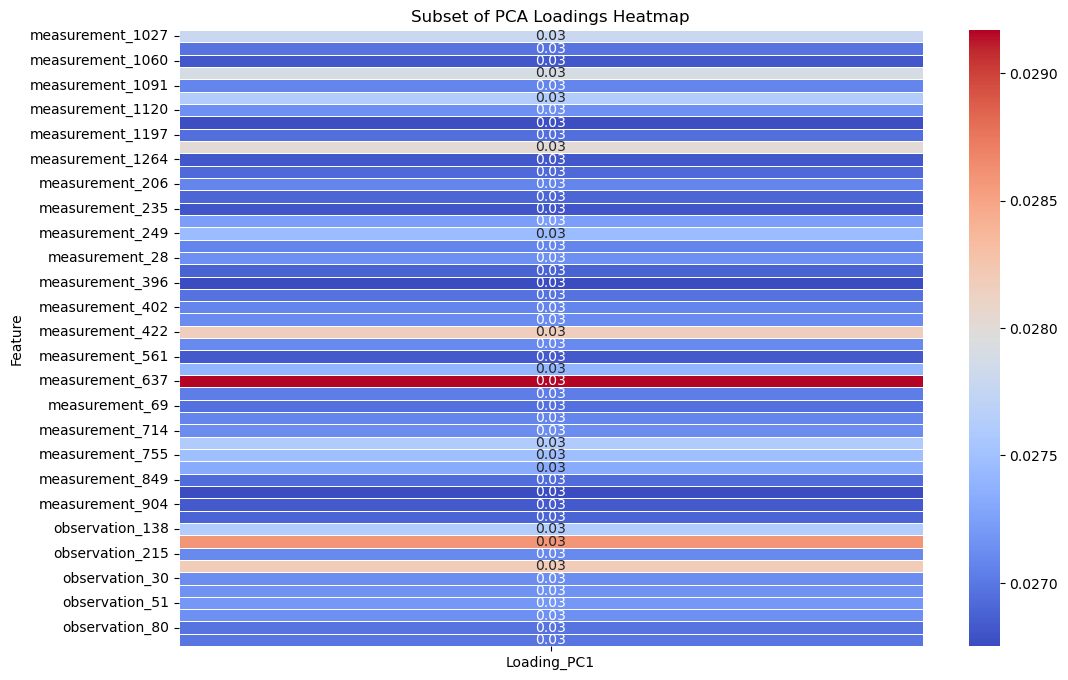

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select a subset of features and principal components
subset_features = loadings['Feature'].iloc[:50]  # Change 10 to the desired number of features
subset_pc_columns = ['Loading_PC1', 'Loading_PC2']  # Change to the desired principal components

# Subset the DataFrame for the selected features and PC loadings
subset_loadings = loadings[loadings['Feature'].isin(subset_features)][['Feature'] + subset_pc_columns]

# Pivot the DataFrame for a heatmap
heatmap_data = subset_loadings.pivot_table(index='Feature', values=subset_pc_columns[0])

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Subset of PCA Loadings Heatmap')
plt.show()


In [18]:

loadings = pd.read_csv("combined_loadings.csv")

loadings # Siin peaks teil loadings df avanema kui kõik töötas nii nagu pidi
loadings.sort_values(by='Loading_PC1', ascending=False)
loadings

,Feature,Loading_PC1,Absolute_Loading_PC1,Feature.1,Loading_PC2,Absolute_Loading_PC2,Feature.2,Loading_PC3,Absolute_Loading_PC3,Feature.3,...,Absolute_Loading_PC17,Feature.17,Loading_PC18,Absolute_Loading_PC18,Feature.18,Loading_PC19,Absolute_Loading_PC19,Feature.19,Loading_PC20,Absolute_Loading_PC20
0,measurement_637,0.029168,0.029168,measurement_637,-0.017191,0.017191,measurement_637,-0.035745,0.035745,measurement_637,...,0.005947,measurement_637,0.002058,0.002058,measurement_637,0.001694,0.001694,measurement_637,-0.016393,0.016393
1,observation_204,0.028583,0.028583,observation_204,0.052606,0.052606,observation_204,-0.002151,0.002151,observation_204,...,0.040165,observation_204,0.038898,0.038898,observation_204,-0.034938,0.034938,observation_204,0.006606,0.006606
2,observation_224,0.028194,0.028194,observation_224,0.041922,0.041922,observation_224,0.004933,0.004933,observation_224,...,0.030767,observation_224,-0.063690,0.063690,observation_224,-0.026163,0.026163,observation_224,0.011224,0.011224
3,measurement_422,0.028162,0.028162,measurement_422,-0.016644,0.016644,measurement_422,-0.035846,0.035846,measurement_422,...,0.000456,measurement_422,0.008282,0.008282,measurement_422,0.011320,0.011320,measurement_422,-0.023532,0.023532
4,measurement_1221,0.028010,0.028010,measurement_1221,-0.012115,0.012115,measurement_1221,-0.034729,0.034729,measurement_1221,...,0.002735,measurement_1221,0.009173,0.009173,measurement_1221,0.017009,0.017009,measurement_1221,-0.017788,0.017788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4858,condition_2161,0.001545,0.001545,condition_2161,0.004886,0.004886,condition_2161,0.002884,0.002884,condition_2161,...,0.009138,condition_2161,0.009927,0.009927,condition_2161,-0.016098,0.016098,condition_2161,-0.019380,0.019380
4859,condition_2394,0.001500,0.001500,condition_2394,0.002474,0.002474,condition_2394,0.006338,0.006338,condition_2394,...,0.003868,condition_2394,0.009958,0.009958,condition_2394,0.006336,0.006336,condition_2394,0.001385,0.001385
4860,condition_1750,0.001423,0.001423,condition_1750,0.003596,0.003596,condition_1750,0.000244,0.000244,condition_1750,...,0.003898,condition_1750,0.007402,0.007402,condition_1750,-0.013328,0.013328,condition_1750,-0.021736,0.021736
4861,condition_53,0.001403,0.001403,condition_53,0.006980,0.006980,condition_53,-0.001001,0.001001,condition_53,...,0.015924,condition_53,0.008711,0.008711,condition_53,-0.020262,0.020262,condition_53,-0.014546,0.014546


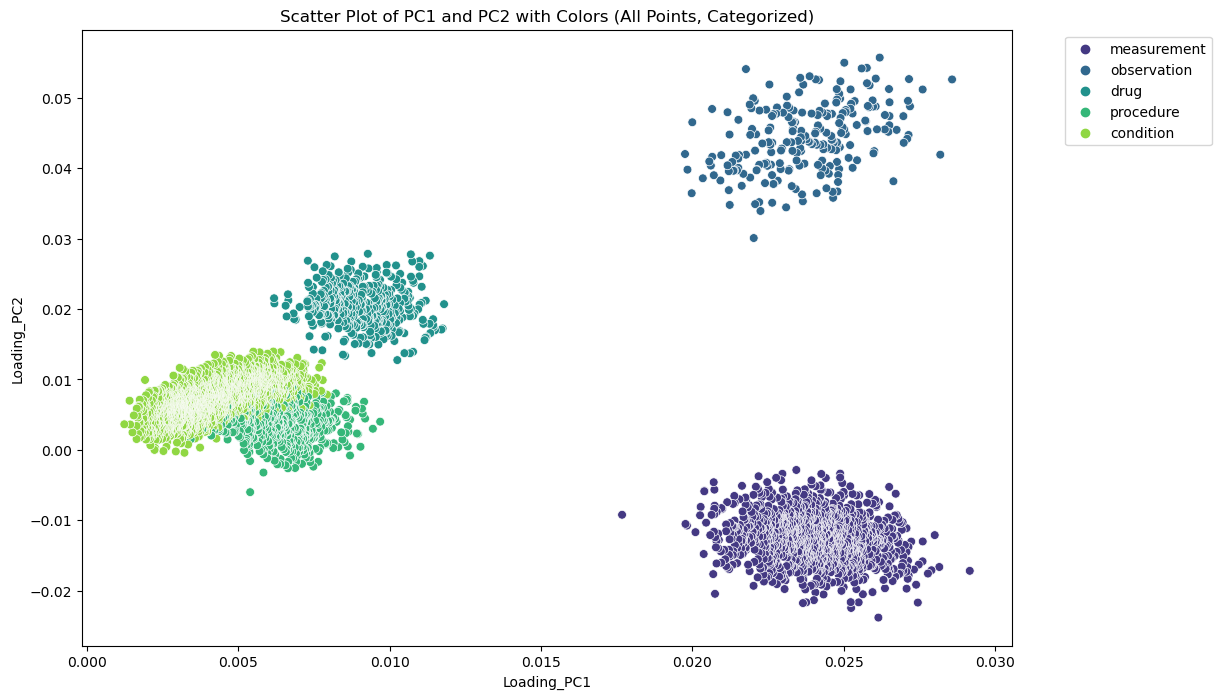

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
loadings = pd.read_csv("combined_loadings.csv")

# Disable scientific notation for display
pd.set_option('display.float_format', lambda x: '%.9f' % x)

# Create a new column for the category based on feature prefixes
loadings['Category'] = loadings['Feature'].apply(lambda x: x.split('_')[0])

# Scatter plot with the entire dataset, colored by category
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x=loadings['Loading_PC1'], y=loadings['Loading_PC2'], hue=loadings['Category'], palette='viridis', s=40)

plt.title('Scatter Plot of PC1 and PC2 with Colors (All Points, Categorized)')
plt.xlabel('Loading_PC1')
plt.ylabel('Loading_PC2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot
plt.show()


In [20]:
loadings

,Feature,Loading_PC1,Absolute_Loading_PC1,Feature.1,Loading_PC2,Absolute_Loading_PC2,Feature.2,Loading_PC3,Absolute_Loading_PC3,Feature.3,...,Feature.17,Loading_PC18,Absolute_Loading_PC18,Feature.18,Loading_PC19,Absolute_Loading_PC19,Feature.19,Loading_PC20,Absolute_Loading_PC20,Category
0,measurement_637,0.029168362,0.029168362,measurement_637,-0.017190785,0.017190785,measurement_637,-0.035744636,0.035744636,measurement_637,...,measurement_637,0.002058148,0.002058148,measurement_637,0.001693586,0.001693586,measurement_637,-0.016392723,0.016392723,measurement
1,observation_204,0.028583363,0.028583363,observation_204,0.052606380,0.052606380,observation_204,-0.002151044,0.002151044,observation_204,...,observation_204,0.038898372,0.038898372,observation_204,-0.034937501,0.034937501,observation_204,0.006606397,0.006606397,observation
2,observation_224,0.028193940,0.028193940,observation_224,0.041922408,0.041922408,observation_224,0.004933474,0.004933474,observation_224,...,observation_224,-0.063689533,0.063689533,observation_224,-0.026163280,0.026163280,observation_224,0.011224097,0.011224097,observation
3,measurement_422,0.028161917,0.028161917,measurement_422,-0.016644321,0.016644321,measurement_422,-0.035846480,0.035846480,measurement_422,...,measurement_422,0.008281854,0.008281854,measurement_422,0.011319691,0.011319691,measurement_422,-0.023531958,0.023531958,measurement
4,measurement_1221,0.028010169,0.028010169,measurement_1221,-0.012115443,0.012115443,measurement_1221,-0.034729065,0.034729065,measurement_1221,...,measurement_1221,0.009172837,0.009172837,measurement_1221,0.017009140,0.017009140,measurement_1221,-0.017787849,0.017787849,measurement
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4858,condition_2161,0.001544834,0.001544834,condition_2161,0.004885876,0.004885876,condition_2161,0.002883829,0.002883829,condition_2161,...,condition_2161,0.009927356,0.009927356,condition_2161,-0.016097958,0.016097958,condition_2161,-0.019379899,0.019379899,condition
4859,condition_2394,0.001499700,0.001499700,condition_2394,0.002473619,0.002473619,condition_2394,0.006337566,0.006337566,condition_2394,...,condition_2394,0.009958039,0.009958039,condition_2394,0.006336428,0.006336428,condition_2394,0.001385187,0.001385187,condition
4860,condition_1750,0.001422504,0.001422504,condition_1750,0.003595895,0.003595895,condition_1750,0.000243771,0.000243771,condition_1750,...,condition_1750,0.007402219,0.007402219,condition_1750,-0.013327725,0.013327725,condition_1750,-0.021736100,0.021736100,condition
4861,condition_53,0.001403384,0.001403384,condition_53,0.006980164,0.006980164,condition_53,-0.001001264,0.001001264,condition_53,...,condition_53,0.008711002,0.008711002,condition_53,-0.020262306,0.020262306,condition_53,-0.014545837,0.014545837,condition
